---
### Network Path and Training Architecture
---

1. Given an input matrix X

2. Construct the network with sigmoid activations to get the output f(W, b|X)--> Encoder()

3. Decode the network to get ~f(X)

4. Obtain the reconstruction error Er = bce(X, ~f(X))

5. Compute the approximation error En = ||f(X) - UV||

6. Minimize over a*Er + En

---
## Algorithm
---



1. Input: X
---
2. Initialization:

*   Pretrain W_, b_ via RBM
*   Initialize U_, V_ with non-negative values
---
3. Using the pretrained weights, update the U_, V_ using the iNMF update rule. This will give a good first linear approximation of U and V.
*   Loop for L times.
---
4. Introduce non-linearities:


*   Using the pretrained weights from (2), construct the network f(W, b|X)
*   Update U and V in the training loop


*   Compute the approximation loss En

*   Construct the decoder network ~f(W,b|X)

*   Compute the reconstruction loss Er

* Update W, b to minimize En + ss(Er)







In [ ]:
## import libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## import sklearn modules
from sklearn.model_selection import train_test_split
## import keras models, layers and optimizers
import tensorflow as tf
import keras
from keras.layers import LeakyReLU
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input, Dot, Masking
from keras.optimizers import Adam
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from keras.constraints import Constraint

Using TensorFlow backend.


In [ ]:
data1 = pd.read_csv("https://raw.githubusercontent.com/Mcpaeis/Independent-Study/master/Data/xns0-inmf-paper.csv", sep=",", header=0)
# https://sixtusdakurah.com/projects/liger/stim_sparse_dfp.csv
data2 = pd.read_csv("https://raw.githubusercontent.com/Mcpaeis/Independent-Study/master/Data/xns1-inmf-paper.csv", sep=",", header=0)
# datan = pd.read_csv("https://raw.githubusercontent.com/Mcpaeis/Independent-Study/master/Data/xns0-inmf-paper.csv")
print("Shape of data 1:", data1.shape)
#data2 = data1.iloc[1:500, ]
print("Shape of data 2:", data2.shape)
#data3 = pd.concat([data1, data2])
#print("Shape of data 3:", data3.shape)
#print("Shape of data n:", datan.shape)

Shape of data 1: (1000, 401)
Shape of data 2: (1000, 601)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,0,0.008902,2.534829,0.004362,0.008315,0.004288,0.009689,0.000925,1.850592,0.003926,0.009784,0.007881,0.007352,0.002088,0.009546,2.042143,0.002571,0.002264,0.003390,0.009663,0.006906,0.005873,0.000223,0.006753,0.002494,0.004620,0.008121,1.516598,0.005334,0.006194,0.002280,0.008156,0.000926,0.954731,0.006866,0.007721,0.006148,0.004271,0.006148,0.007077,...,1.305656,2.424387,1.095865,2.667955,2.653360,0.705421,0.036589,0.628029,3.391675,2.716836,2.834260,0.085274,2.951186,3.000008,0.632903,1.414103,0.005116,0.435609,2.121172,1.029565,0.408077,1.347209,1.470069,3.212067,1.665261,2.335919,3.226944,1.840497,1.951326,0.006348,0.031788,1.823886,0.118889,0.987714,0.131015,0.896814,0.879306,1.494660,2.175169,1.404495
1,1,0.003033,0.008003,0.004022,0.009925,0.000318,0.005226,0.004609,0.000635,0.005027,0.002215,0.006028,0.008099,0.003635,0.002835,0.004827,0.005906,0.006250,0.001911,0.274384,0.009003,0.008970,0.004168,0.003449,0.000197,0.009236,0.007514,0.008604,0.005904,0.007262,0.002111,1.261564,0.007830,0.001306,0.006920,0.004630,0.009669,0.006414,0.007405,0.000679,...,0.435277,0.351266,0.158249,1.492178,0.001188,1.424943,0.883238,1.962224,0.006602,0.259514,0.784174,1.719533,0.557130,0.427806,0.908035,0.257152,0.042224,0.257208,0.665718,0.002915,0.493324,1.016972,0.006290,0.367797,0.926376,0.604345,0.665562,0.100625,1.607162,0.777269,0.380055,2.686059,0.636924,1.046360,1.605778,1.323561,1.477761,1.777076,0.288062,0.838839
2,2,1.441777,0.003417,2.488009,0.006158,0.005331,0.007442,0.008394,0.005678,0.009546,0.001898,0.003241,0.004565,0.004070,0.009416,0.007121,2.437544,0.009342,0.003235,0.000162,0.002436,0.001949,0.005727,0.001372,0.295216,0.008934,0.008430,0.000993,0.001222,0.006803,0.003385,0.001771,0.001922,0.005548,0.008568,0.002189,0.000511,0.002570,0.005562,0.002053,...,0.009939,1.087811,2.278941,2.635385,0.002784,2.682909,0.007013,1.781886,2.329346,0.207305,1.111120,0.512421,1.208821,0.015807,2.466601,1.587002,1.515718,2.635458,0.283135,2.510238,0.510282,0.187106,0.217971,0.563351,1.072569,0.002005,1.332327,0.372223,0.097113,1.821238,0.267926,0.825565,3.006253,2.590429,0.492977,1.252410,0.782119,0.527838,0.090281,1.310410
3,3,0.001075,0.006045,0.000146,1.155767,0.007984,0.003719,0.002759,0.000454,0.006561,0.007940,0.009949,0.005067,0.006254,0.004366,0.007906,1.848511,0.007665,1.430342,0.002109,1.948036,0.005353,0.006027,0.005565,0.004246,0.002204,0.003822,1.133928,0.004268,0.006098,0.007077,0.008819,0.000837,0.000261,0.008142,0.003312,0.002000,0.003772,0.001714,0.000213,...,1.722936,2.933320,2.361335,1.896267,0.675011,1.254173,1.497027,1.678026,0.309537,0.488027,2.534213,0.169712,2.631988,0.907093,1.247059,0.964147,0.078402,0.559018,2.386406,0.982252,2.013680,0.715451,0.135542,0.365816,0.836849,0.127012,1.196276,1.556711,0.120164,0.000624,2.090562,0.006964,0.007592,1.289106,0.188653,0.001932,0.897816,2.782726,0.338218,1.314088
4,4,1.263001,0.001746,0.008272,0.007136,0.008426,0.004846,0.001510,0.004273,0.009559,0.008937,1.020097,0.000850,2.079235,0.005535,0.001358,0.005533,0.007863,0.008482,0.007822,0.009995,0.009844,0.008617,0.009143,0.000450,0.005263,1.300315,0.001910,0.001620,0.006892,0.009162,0.001955,0.008158,0.003055,0.006286,0.005573,1.356961,0.008811,0.007984,0.003787,...,1.590831,2.150370,0.000045,0.472517,1.861525,0.140858,0.005420,0.884259,1.485098,0.227173,0.055109,0.014021,1.471754,0.928657,0.004791,0.525702,0.664149,0.110745,0.317750,0.331914,0.978406,1.910267,1.093921,1.389781,0.006266,1.651345,1.603148,0.490710,0.948104,1.800054,0.687664,0.363053,1.525669,1.744874,3.647987,1.344359,0.497851,0.199667,0.007687,3.280799


In [ ]:
# get the extracted columns
x1_genes = data1['Unnamed: 0']
print(x1_genes)
x2_genes = data2['Unnamed: 0']
print(x2_genes)

0        0
1        1
2        2
3        3
4        4
      ... 
995    995
996    996
997    997
998    998
999    999
Name: Unnamed: 0, Length: 1000, dtype: int64
0        0
1        1
2        2
3        3
4        4
      ... 
995    995
996    996
997    997
998    998
999    999
Name: Unnamed: 0, Length: 1000, dtype: int64


In [ ]:
data1.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,0,0.008902,2.534829,0.004362,0.008315,0.004288,0.009689,0.000925,1.850592,0.003926,0.009784,0.007881,0.007352,0.002088,0.009546,2.042143,0.002571,0.002264,0.003390,0.009663,0.006906,0.005873,0.000223,0.006753,0.002494,0.004620,0.008121,1.516598,0.005334,0.006194,0.002280,0.008156,0.000926,0.954731,0.006866,0.007721,0.006148,0.004271,0.006148,0.007077,...,1.305656,2.424387,1.095865,2.667955,2.653360,0.705421,0.036589,0.628029,3.391675,2.716836,2.834260,0.085274,2.951186,3.000008,0.632903,1.414103,0.005116,0.435609,2.121172,1.029565,0.408077,1.347209,1.470069,3.212067,1.665261,2.335919,3.226944,1.840497,1.951326,0.006348,0.031788,1.823886,0.118889,0.987714,0.131015,0.896814,0.879306,1.494660,2.175169,1.404495
1,1,0.003033,0.008003,0.004022,0.009925,0.000318,0.005226,0.004609,0.000635,0.005027,0.002215,0.006028,0.008099,0.003635,0.002835,0.004827,0.005906,0.006250,0.001911,0.274384,0.009003,0.008970,0.004168,0.003449,0.000197,0.009236,0.007514,0.008604,0.005904,0.007262,0.002111,1.261564,0.007830,0.001306,0.006920,0.004630,0.009669,0.006414,0.007405,0.000679,...,0.435277,0.351266,0.158249,1.492178,0.001188,1.424943,0.883238,1.962224,0.006602,0.259514,0.784174,1.719533,0.557130,0.427806,0.908035,0.257152,0.042224,0.257208,0.665718,0.002915,0.493324,1.016972,0.006290,0.367797,0.926376,0.604345,0.665562,0.100625,1.607162,0.777269,0.380055,2.686059,0.636924,1.046360,1.605778,1.323561,1.477761,1.777076,0.288062,0.838839
2,2,1.441777,0.003417,2.488009,0.006158,0.005331,0.007442,0.008394,0.005678,0.009546,0.001898,0.003241,0.004565,0.004070,0.009416,0.007121,2.437544,0.009342,0.003235,0.000162,0.002436,0.001949,0.005727,0.001372,0.295216,0.008934,0.008430,0.000993,0.001222,0.006803,0.003385,0.001771,0.001922,0.005548,0.008568,0.002189,0.000511,0.002570,0.005562,0.002053,...,0.009939,1.087811,2.278941,2.635385,0.002784,2.682909,0.007013,1.781886,2.329346,0.207305,1.111120,0.512421,1.208821,0.015807,2.466601,1.587002,1.515718,2.635458,0.283135,2.510238,0.510282,0.187106,0.217971,0.563351,1.072569,0.002005,1.332327,0.372223,0.097113,1.821238,0.267926,0.825565,3.006253,2.590429,0.492977,1.252410,0.782119,0.527838,0.090281,1.310410
3,3,0.001075,0.006045,0.000146,1.155767,0.007984,0.003719,0.002759,0.000454,0.006561,0.007940,0.009949,0.005067,0.006254,0.004366,0.007906,1.848511,0.007665,1.430342,0.002109,1.948036,0.005353,0.006027,0.005565,0.004246,0.002204,0.003822,1.133928,0.004268,0.006098,0.007077,0.008819,0.000837,0.000261,0.008142,0.003312,0.002000,0.003772,0.001714,0.000213,...,1.722936,2.933320,2.361335,1.896267,0.675011,1.254173,1.497027,1.678026,0.309537,0.488027,2.534213,0.169712,2.631988,0.907093,1.247059,0.964147,0.078402,0.559018,2.386406,0.982252,2.013680,0.715451,0.135542,0.365816,0.836849,0.127012,1.196276,1.556711,0.120164,0.000624,2.090562,0.006964,0.007592,1.289106,0.188653,0.001932,0.897816,2.782726,0.338218,1.314088
4,4,1.263001,0.001746,0.008272,0.007136,0.008426,0.004846,0.001510,0.004273,0.009559,0.008937,1.020097,0.000850,2.079235,0.005535,0.001358,0.005533,0.007863,0.008482,0.007822,0.009995,0.009844,0.008617,0.009143,0.000450,0.005263,1.300315,0.001910,0.001620,0.006892,0.009162,0.001955,0.008158,0.003055,0.006286,0.005573,1.356961,0.008811,0.007984,0.003787,...,1.590831,2.150370,0.000045,0.472517,1.861525,0.140858,0.005420,0.884259,1.485098,0.227173,0.055109,0.014021,1.471754,0.928657,0.004791,0.525702,0.664149,0.110745,0.317750,0.331914,0.978406,1.910267,1.093921,1.389781,0.006266,1.651345,1.603148,0.490710,0.948104,1.800054,0.687664,0.363053,1.525669,1.744874,3.647987,1.344359,0.497851,0.199667,0.007687,3.280799


In [ ]:
# melt data
X1 = pd.melt(data1, id_vars=['Unnamed: 0'], var_name='cell', value_name='val')
X1.rename(columns = {'Unnamed: 0':'gene'}, inplace = True)
#X1 = X1.loc[X1['gene'].isin(x2_genes)] ## select genes common to X1 and X2
X1['gene'] = X1['gene'].astype('category')
X1['gene'] = X1['gene'].cat.codes
X1['cell'] = X1['cell'].astype('category')
X1['cell'] = X1['cell'].cat.codes
X1.head()

,gene,cell,val
0,0,0,0.008902
1,1,0,0.003033
2,2,0,1.441777
3,3,0,0.001075
4,4,0,1.263001


In [ ]:
# melt data
X2 = pd.melt(data2, id_vars=['Unnamed: 0'], var_name='cell', value_name='val')
X2.rename(columns = {'Unnamed: 0':'gene'}, inplace = True)
X2['gene'] = X2['gene'].astype('category')
X2['gene'] = X2['gene'].cat.codes
X2['cell'] = X2['cell'].astype('category')
X2['cell'] = X2['cell'].cat.codes
X2.head()

,gene,cell,val
0,0,0,0.004465
1,1,0,0.476762
2,2,0,0.000520
3,3,0,0.164034
4,4,0,0.006510


In [ ]:
n_rows1 = len((X1.cell).unique())
n_cols1 = len((X1.gene).unique())
print(n_rows1)
print(n_cols1)
n_rows2 = len((X2.cell).unique())
n_cols2 = len((X2.gene).unique())
print(n_rows2)
print(n_cols2)
# print(n_rows_)
# print(n_cols_)

400
1000
600
1000


In [ ]:
## Load pre-trained embeddings
W_Embedding = pd.read_csv("https://raw.githubusercontent.com/Mcpaeis/Independent-Study/master/Data/W-Embedding.csv", sep=",", header=None)
H1_Embedding = pd.read_csv("https://raw.githubusercontent.com/Mcpaeis/Independent-Study/master/Data/H1-Embedding.csv", sep=",", header=None)
H2_Embedding = pd.read_csv("https://raw.githubusercontent.com/Mcpaeis/Independent-Study/master/Data/H2-Embedding.csv", sep=",", header=None)
print("W_Embedding shape: ", W_Embedding.shape)
print("H1_Embedding shape: ", H1_Embedding.shape)
print("H2_Embedding shape: ", H2_Embedding.shape)

W_Embedding shape:  (1001, 20)
H1_Embedding shape:  (401, 20)
H2_Embedding shape:  (601, 20)


In [ ]:
W_Embedding.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000220,0.000684,0.476492,0.000274,0.000123,0.000258,0.486931,0.599326,0.000430,0.000296,0.000269,0.000382,0.478074,0.478495,0.000328,0.477181,0.000170,0.000325,0.000295,0.495727
1,0.137011,0.510143,0.029325,0.055343,-0.000000,0.141873,0.129369,0.582947,0.687479,0.420117,0.428640,0.219310,0.043705,0.000536,0.086833,0.104153,0.000211,0.017845,0.292212,0.219307
2,0.094078,0.570294,0.058597,0.125282,0.069115,0.052335,0.007603,0.570525,0.603606,0.366183,0.434937,0.096599,0.049111,0.082425,0.224457,0.115918,0.034187,0.117011,0.196096,0.011353
3,0.084954,0.260520,0.119241,0.059153,0.036019,0.175406,0.096276,0.556937,1.022796,0.163573,0.457635,0.125126,0.013661,0.037441,0.221405,0.017494,0.055771,0.046008,0.078756,0.001652
4,0.007898,0.485009,0.134871,0.061983,0.019976,0.108727,0.013886,0.480906,1.006610,0.200201,0.312326,0.015801,0.019524,0.032674,0.040914,-0.000000,0.006198,0.159255,0.018271,0.106576


In [ ]:
## create keras model
dim_embeddings = 20

## rows
row_input = Input(shape=[1], name='X1-Row')
masked_row_input = Masking(mask_value=-10)(row_input)
row_embedding = Embedding(n_rows1 + 1, dim_embeddings, weights = [H1_Embedding],
                          trainable = True, name="H1-Embedding",
                          embeddings_constraint=tf.keras.constraints.NonNeg())(masked_row_input)
#row_bias = Embedding(n_rows1 + 1, bias, name="Row-Bias")(row_input)

## cols
col_input = Input(shape=[1],name='X2-Row')
masked_col_input = Masking(mask_value=-10)(col_input)
col_embedding = Embedding(n_rows2 + 1, dim_embeddings, name="H2-Embedding",
                          weights = [H2_Embedding],
                          trainable = True,
                          embeddings_constraint=tf.keras.constraints.NonNeg())(masked_col_input)
#col_bias = Embedding(n_rows2 + 1, bias, name="Col-Bias")(col_input)

## cols
rc_input = Input(shape=[1], name='RC-Column')
masked_rc_input = Masking(mask_value=-10)(rc_input)
# cols 1 or cols 2 will do
rc_embedding = Embedding(n_cols1 + 1, dim_embeddings, name="W-Embedding",
                         weights = [W_Embedding],
                          trainable = True,
                         embeddings_constraint=tf.keras.constraints.NonNeg())(masked_rc_input)
rc_embedding_t = keras.layers.Permute((2, 1))(rc_embedding)
#rc_bias = Embedding(n_cols_ + 1, bias, name="RC-Bias")(rc_input)

## matrix product
matrix_product = Dot(axes=(1, 2))([row_embedding, rc_embedding_t]) #([row_embedding, rc_embedding_t])
matrix_product = Dropout(0.2)(matrix_product)
matrix_product_ = Dot(axes=(1, 2))([col_embedding, rc_embedding_t])
matrix_product_ = Dropout(0.2)(matrix_product_)

#matrix_product_gen = multiply([row_embedding, col_embedding, rc_embedding])

## add bias terms
# input_terms = concatenate([matrix_product, rc_bias, row_bias])
input_terms = Flatten()(matrix_product)
# input_terms_ = concatenate([matrix_product, rc_bias, col_bias])
input_terms_ = Flatten()(matrix_product_)

## Construct the linear update rule.

## add dense layers
dense_1 = Dense(150, activation='relu', name = "Dense1")(input_terms)
dense_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(120, activation="relu", name = "Dense2")(dense_1)
dense_2 = Dropout(0.2)(dense_2)
dense_3 = Dense(90, activation="relu", name = "Dense3")(dense_2)
dense_3 = Dropout(0.2)(dense_3)
dense_4 = Dense(60, activation="relu", name = "Dense4")(dense_3)
dense_4 = Dropout(0.2)(dense_4)
dense_5 = Dense(20, activation="relu", name = "Dense5")(dense_4)
dense_5 = Dropout(0.2)(dense_5)
result = Dense(1, activation='softmax', name='X1-Output')(dense_5)
# add dense layers
dense_1_ = Dense(150, activation="relu", name = "Dense1_")(input_terms_)
dense_1_ = Dropout(0.2)(dense_1_)
dense_2_ = Dense(120, activation="relu", name = "Dense2_")(dense_1_)
dense_2_ = Dropout(0.2)(dense_2_)
dense_3_ = Dense(90, activation="relu", name = "Dense3_")(dense_2_)
dense_3_ = Dropout(0.2)(dense_3_)
dense_4_ = Dense(60, activation="relu", name = "Dense4_")(dense_3_)
dense_4_ = Dropout(0.2)(dense_4_)
dense_5_ = Dense(20, activation="relu", name = "Dense5_")(dense_4_)
dense_5_ = Dropout(0.2)(dense_5_)
result_ = Dense(1, activation='softmax', name='X2-Output')(dense_5_)



## define model with 2 inputs and 1 output
model_mf = Model(inputs=[row_input, col_input, rc_input], outputs=[result, result_])

## show model summary
model_mf.summary()

print(model_mf.inputs)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RC-Column (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
X1-Row (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
masking_27 (Masking)            (None, 1)            0           RC-Column[0][0]                  
__________________________________________________________________________________________________
X2-Row (InputLayer)             (None, 1)            0                                            
____________________________________________________________________________________________

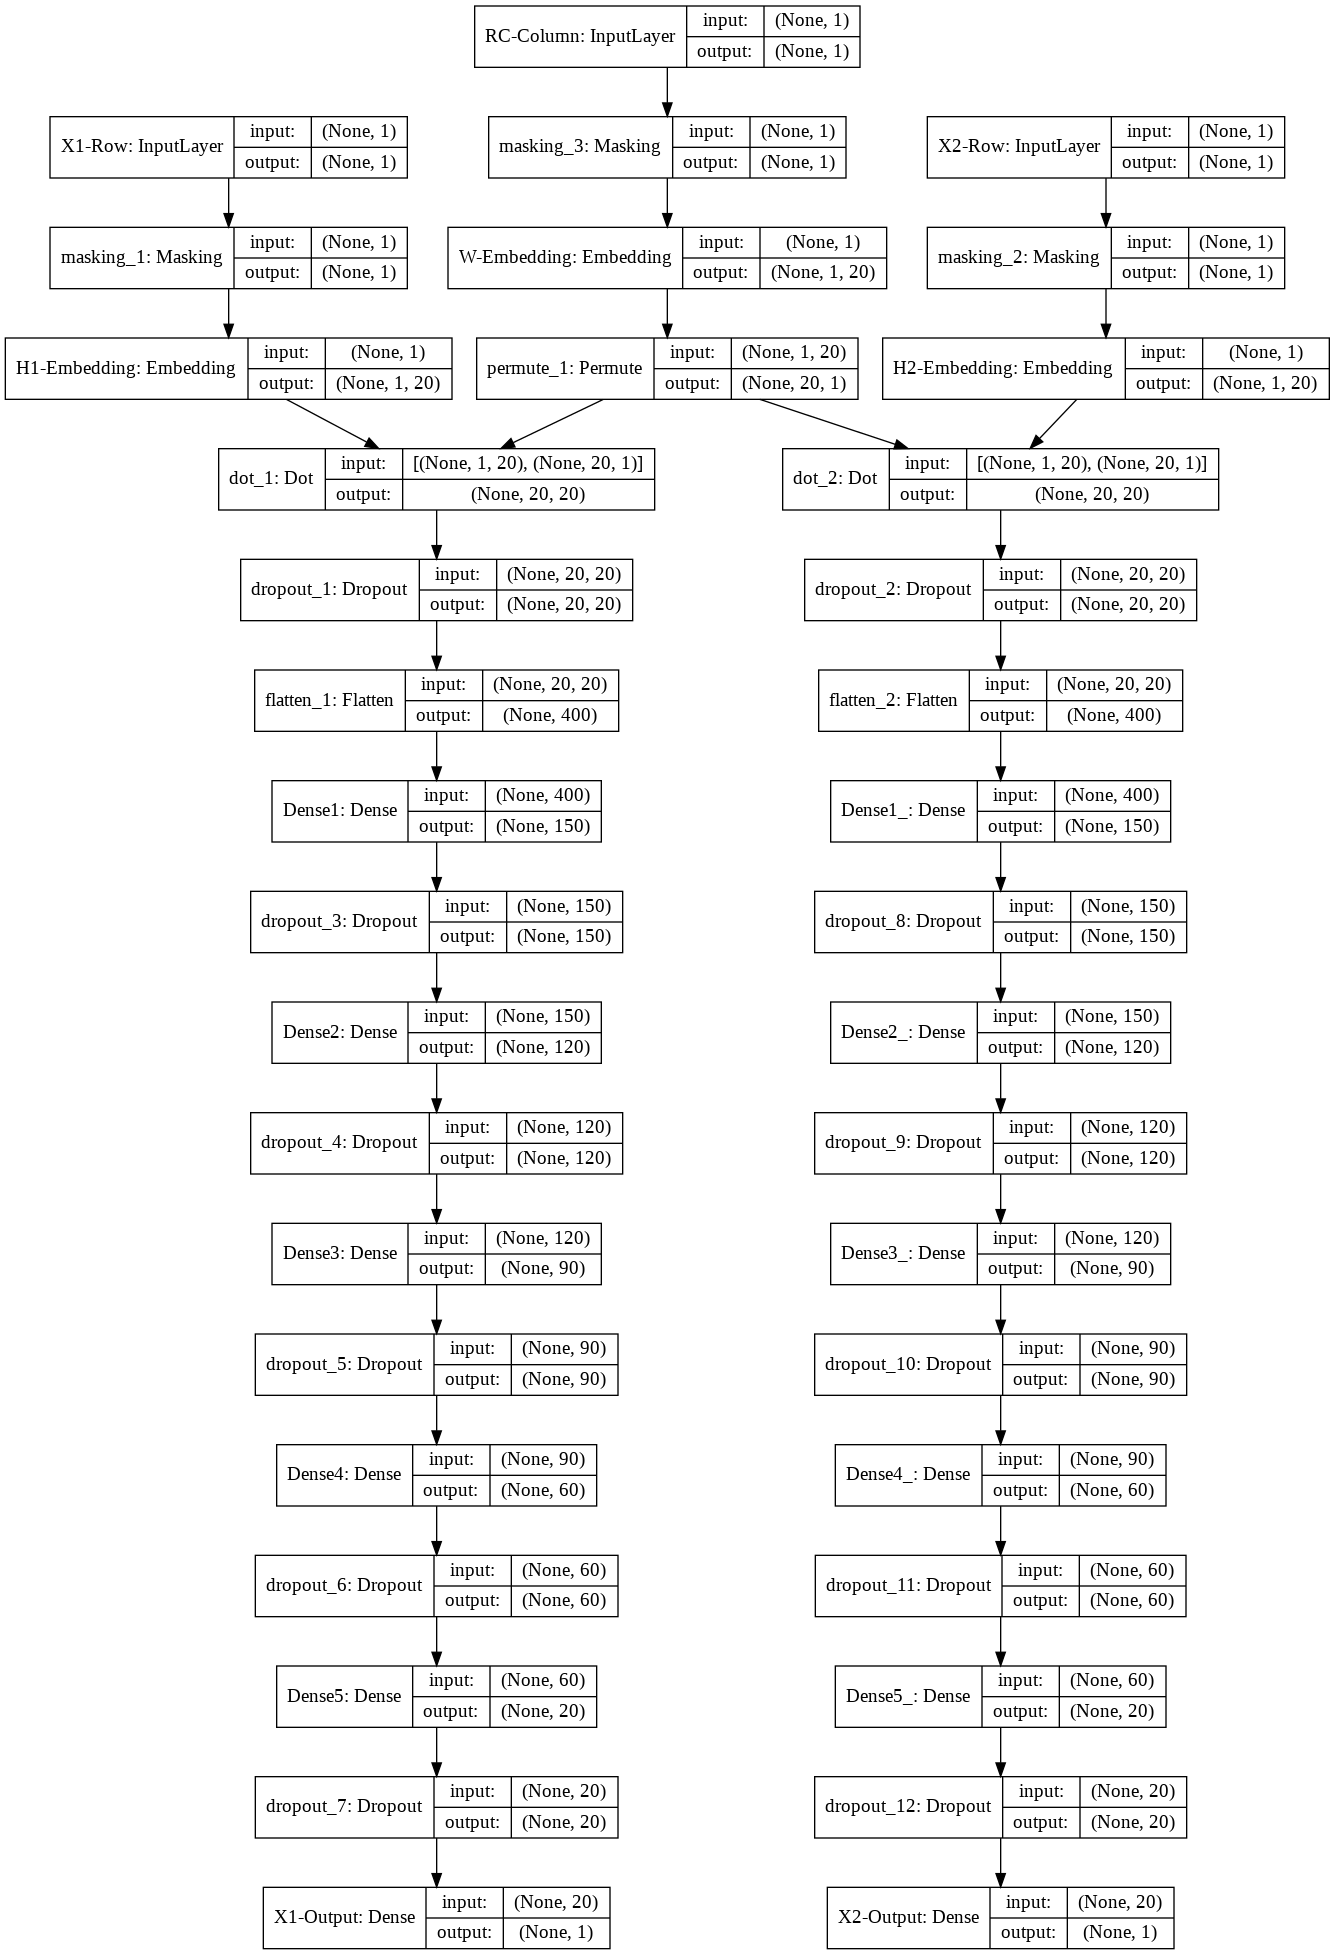

In [ ]:
keras.utils.plot_model(model_mf, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
## Get indexes and inputs
special_value = -10.0
r = (np.array(X1['cell']).reshape(-1, 1))
print("r shape: ",r.shape[0])
c = (np.array(X2['cell']).reshape(-1, 1))
print("c shape: ",c.shape)
rc = (np.array(X1['gene']).reshape(-1, 1))
print("rc shape: ", rc.shape)
max_len = max(r.shape[0], c.shape[0], rc.shape[0])
print("max len: ", max_len)
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([r, c, rc], value=-10, padding="post")
rp = padded_sequence[0]
print("rp shape: ",rp.shape)
cp = padded_sequence[1]
print("cp shape: ",cp.shape)
rcp = padded_sequence[2]
print("rcp shape: ",rcp.shape)
padded_target = tf.keras.preprocessing.sequence.pad_sequences([X1['val'], X2['val']], value=-10, padding="post")
val1 = padded_target[0]
val2 = padded_target[1]

r shape:  400000
c shape:  (600000, 1)
rc shape:  (400000, 1)
max len:  600000
rp shape:  (600000, 1)
cp shape:  (600000, 1)
rcp shape:  (600000, 1)


In [ ]:
## specify learning rate (or use the default)
opt_adam = Adam(lr = 0.002)

## compile model
model_mf.compile(optimizer = opt_adam, loss = ['mse', 'mse'], metrics = ['mean_squared_error'])

## fit model
history_mf = model_mf.fit({"X1-Row": rp, "X2-Row": cp, "RC-Column": rcp},
                          {"X1-Output": val1, "X2-Output": val2},
                          batch_size = 256,
                          validation_split = 0.3,
                          epochs = 100,
                          verbose = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 420000 samples, validate on 180000 samples
Epoch 1/100
420000/420000 [==============================] - 19s 46us/step - loss: 7.4884 - X1-Output_loss: 6.5995 - X2-Output_loss: 0.8887 - X1-Output_mean_squared_error: 6.5997 - X2-Output_mean_squared_error: 0.8887 - val_loss: 121.8683 - val_X1-Output_loss: 121.0000 - val_X2-Output_loss: 0.8684 - val_X1-Output_mean_squared_error: 121.0000 - val_X2-Output_mean_squared_error: 0.8683
Epoch 2/100
420000/420000 [==============================] - 19s 45us/step - loss: 7.4884 - X1-Output_loss: 6.5992 - X2-Output_loss: 0.8887 - X1-Output_mean_squared_error: 6.5997 - X2-Output_mean_squared_error: 0.8887 - val_loss: 121.8683 - val_X1-Output_loss: 121.0000 - val_X2-Output_loss: 0.8684 - val_X1-Output_mean_squared_error: 121.0000 - val_X2-Output_mean_squared_error: 0.8683
Epoch 3/100
420000/420000 [==============================] - 19s 45us/step - loss: 7.4884 - X1-Output_loss: 6.6002 - X2-Output_loss: 0.8887 - X1-Output_mean_squared_error: 6.

In [ ]:
# print out the layers
index = 0
for lay in model_mf.layers:
  print(lay.name, 'at index: ', index)
  index+=1

RC-Column at index:  0
X1-Row at index:  1
masking_27 at index:  2
X2-Row at index:  3
masking_25 at index:  4
W-Embedding at index:  5
masking_26 at index:  6
H1-Embedding at index:  7
permute_9 at index:  8
H2-Embedding at index:  9
dot_17 at index:  10
dot_18 at index:  11
dropout_37 at index:  12
dropout_38 at index:  13
flatten_17 at index:  14
flatten_18 at index:  15
Dense1 at index:  16
Dense1_ at index:  17
dropout_39 at index:  18
dropout_44 at index:  19
Dense2 at index:  20
Dense2_ at index:  21
dropout_40 at index:  22
dropout_45 at index:  23
Dense3 at index:  24
Dense3_ at index:  25
dropout_41 at index:  26
dropout_46 at index:  27
Dense4 at index:  28
Dense4_ at index:  29
dropout_42 at index:  30
dropout_47 at index:  31
Dense5 at index:  32
Dense5_ at index:  33
dropout_43 at index:  34
dropout_48 at index:  35
X1-Output at index:  36
X2-Output at index:  37


In [ ]:
## get weights of embedding matrix
W = model_mf.layers[5].get_weights()[0]
H1 = model_mf.layers[7].get_weights()[0]
H2 = model_mf.layers[9].get_weights()[0]
print("W shape: ", W.shape)
print("H1 shape: ", H1.shape)
print("H2 shape: ", H2.shape)

W shape:  (1001, 20)
H1 shape:  (401, 20)
H2 shape:  (601, 20)


In [ ]:
(pd.DataFrame(W)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000220,0.000684,0.476492,0.000274,0.000123,0.000258,0.486931,0.599326,0.000430,0.000296,0.000269,0.000382,0.478074,0.478495,0.000328,0.477181,0.000170,0.000325,0.000295,0.495727
1,0.137011,0.510143,0.029325,0.055343,-0.000000,0.141873,0.129369,0.582947,0.687479,0.420117,0.428640,0.219310,0.043705,0.000536,0.086833,0.104153,0.000211,0.017845,0.292212,0.219307
2,0.094078,0.570294,0.058597,0.125282,0.069115,0.052335,0.007603,0.570525,0.603606,0.366183,0.434936,0.096599,0.049111,0.082425,0.224457,0.115918,0.034187,0.117011,0.196096,0.011353
3,0.084954,0.260520,0.119241,0.059153,0.036019,0.175407,0.096276,0.556937,1.022796,0.163573,0.457635,0.125126,0.013661,0.037441,0.221404,0.017494,0.055771,0.046008,0.078756,0.001652
4,0.007898,0.485009,0.134871,0.061983,0.019976,0.108727,0.013886,0.480906,1.006610,0.200201,0.312326,0.015801,0.019524,0.032674,0.040914,-0.000000,0.006198,0.159255,0.018271,0.106576


In [ ]:
def plot3D(df, title):
  my_dpi=96
  plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
  pca = PCA(n_components=3)
  df = pd.DataFrame(df)
  pca.fit(df)
  # Store results of PCA in a data frame
  result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)], index=df.index)

  # Plot initialisation
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], s=60)

  # label the axes
  ax.set_title(title)
  plt.show()

<Figure size 480x480 with 0 Axes>

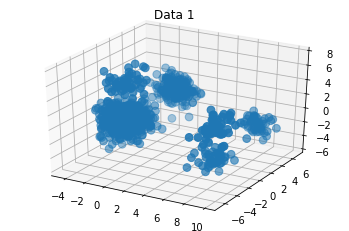

<Figure size 480x480 with 0 Axes>

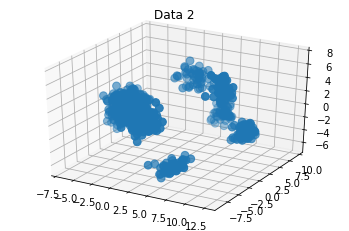

<Figure size 480x480 with 0 Axes>

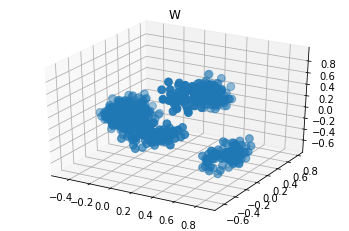

In [ ]:
d1 = data1.drop(columns=['Unnamed: 0'])
d2 = data2.drop(columns=['Unnamed: 0'])
plot3D(d1, "Data 1")
plot3D(d2, "Data 2")
plot3D(pd.DataFrame(W), "W")